# Modeling
## Predicting Rates of Chronic Absenteeism



### Imports 

In [84]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn import tree, metrics
from io import StringIO  
from IPython.display import Image  
#import pydotplus

import matplotlib.style as style
style.use('fivethirtyeight')

In [85]:
#load processed data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed'
os.chdir(path)

In [86]:
#load data for regression and classification models
df_regressor = pd.read_csv('more_variables_attendance_2013_18_regressor.csv', dtype={'District_Number': object})

df_classifier = pd.read_csv('more_variables_attendance_2013_18_classifier.csv', dtype={'District_Number': object})

In [87]:
#check to ensure District Number is correctly an object, not int
df_regressor.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

This time we will try the models and maintain the feature `% Chronically Absent`, as we want to increase model accuracy.

In [88]:
#create dummy variables for the two data frames
df_regressor_dummies = pd.get_dummies(df_regressor)

#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier_dummies = pd.get_dummies(df_classifier.drop(columns=['Chronically_Absent_Next_Year']))

#save target variable for classification
target_classifier = df_classifier['Chronically_Absent_Next_Year']

print(df_classifier_dummies.shape)
print(df_regressor_dummies.shape)

(448835, 73)
(448835, 74)


In [89]:
#define variables for regressor
X = df_regressor_dummies.drop(columns=['Next Year % Chronically Absent'])
y = df_regressor_dummies['Next Year % Chronically Absent']

In [90]:
#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Modeling

### Initial Benchmark 
#### Using Last Year's % Chronically Absent to Predict Next Year's

In [32]:
#create linear regression with only previous year's '% Chronically Absent' as X variable
dummy_lr = LinearRegression().fit(pd.DataFrame(X_train['% Chronically Absent']), y_train)

In [33]:
#make predictions
y_dum_tr_pred = dummy_lr.predict(pd.DataFrame(X_train['% Chronically Absent']))
y_dumm_te_pred = dummy_lr.predict(pd.DataFrame(X_test['% Chronically Absent']))

In [34]:
#get R2 - train, test
r2 = r2_score(y_train, y_dum_tr_pred), r2_score(y_test, y_dumm_te_pred)
print('r2:', r2)

r2: (0.6629387636783622, 0.6379189299689096)


In [35]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_dum_tr_pred), mean_absolute_error(y_test, y_dumm_te_pred)
print('mae:', mae)

mae: (7.493247913833839, 7.731187252475798)


In [36]:
# MSE - train, test
mse = mean_squared_error(y_train, y_dum_tr_pred), mean_squared_error(y_test, y_dumm_te_pred)
print('mse:', mse)

mse: (105.7232210816451, 112.96321736840633)


It seems that if one only used last year's `% Chronically Absent` you would predict `Next Year % Chronically Absent` correctly 63.8% of the time. So any future models would need to improve on that.

### Linear Regression Model

In [91]:
lm = LinearRegression().fit(X_train, y_train)

In [92]:
#Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [93]:
#Assess model performance
# r^2 - train, test
r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
print('r2:', r2)

r2: (0.847150018751543, 0.6862648134079694)


In [94]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
print('mae:', mae)

mae: (4.8944715287363305, 7.115199420440165)


In [95]:
# MSE - train, test
mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
print('mse:', mse)

mse: (47.443125515116115, 97.62840654684464)


### Random Forest Regression Model

In [96]:
rf_model = RandomForestRegressor()

In [97]:
%%time
rf_model.fit(X_train, y_train)
y_tr_pred = rf_model.predict(X_train)
y_te_pred = rf_model.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

CPU times: user 12min 28s, sys: 19.8 s, total: 12min 47s
Wall time: 13min 37s


(0.9883989097838864, 0.7010111034155115)

In [98]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(1.1704781354436808, 6.883194158144508)

In [99]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(3.600863897657942, 93.03964233600695)

## Initial Classification Models

In [100]:
#define variables for classifier
X_c = df_classifier_dummies
y_c = target_classifier

In [101]:
# dividing X_c, y_c into train and test data 
#X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, random_state = 0) 

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X_c):
    X_train, X_test = X_c.iloc[train_index, :], X_c.iloc[test_index,:]
    y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]

### Establish Baseline
#### Using Last Year's % Chronically Absent to Predict Next Year's

In [102]:
# training a DescisionTreeClassifier 
baseline_dtree_model = DecisionTreeClassifier(max_depth = 2).fit(pd.DataFrame(X_Chronically Absentin['% Chronically Absent']), y_train) 
baseline_dtree_predDataFramens = baseline_dtree_model.predict(pd.DataFrame(X_test['% Chronically Absent']))
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, baseline_dtree_predictions) 

SyntaxError: invalid syntax (<ipython-input-102-34041d61e72c>, line 2)

In [ ]:
print(baseline_dtree_model.score(pd.DataFrame(X_test['% Chronically Absent']), y_test))
print(cm)
print(classification_report(y_test, baseline_dtree_predictions))

This suggests that a model would have to outperform 76.9% to be considered an improvement over the baseline.

### Decision Tree

In [ ]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [ ]:
print(dtree_model.score(X_test, y_test))
print(cm)
print(classification_report(y_test, dtree_predictions))

In [ ]:
plt.style.use('classic')
#plot decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(dtree_model, class_names=dtree_model.classes_, feature_names=X_train.columns)
plt.show()

### Tuning Decision Tree Classifier

In [70]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 9),
              #"max_features": randint(1, 9),
              #"min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 4}
Best score is 0.7882060996674503


In [71]:
# Predict the labels of the test set: y_pred
y_pred = tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 8062    23  5084]
 [   28  6768  5355]
 [ 3338  2565 44436]]
              precision    recall  f1-score   support

        High       0.71      0.61      0.66     13169
         Low       0.72      0.56      0.63     12151
      Medium       0.81      0.88      0.84     50339

    accuracy                           0.78     75659
   macro avg       0.75      0.68      0.71     75659
weighted avg       0.78      0.78      0.78     75659



In [74]:
#create model with tuned hyperparameters
tuned_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)

# Fit it to the data
tuned_tree.fit(X_train, y_train)
y_pred = tree_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.71      0.61      0.66     13169
         Low       0.72      0.56      0.63     12151
      Medium       0.81      0.88      0.84     50339

    accuracy                           0.78     75659
   macro avg       0.75      0.68      0.71     75659
weighted avg       0.78      0.78      0.78     75659



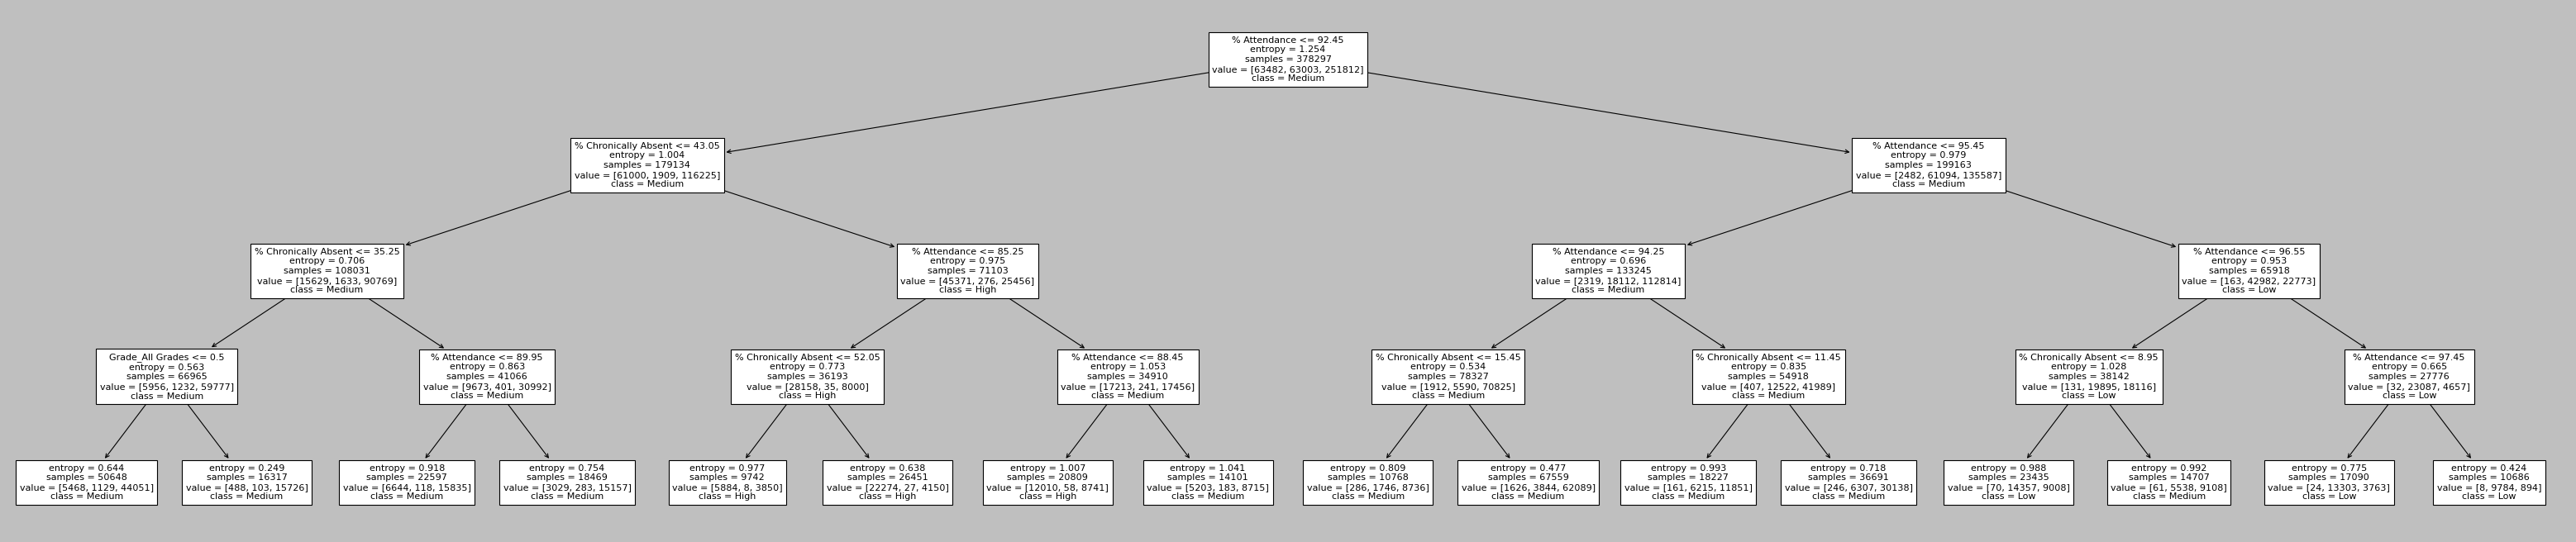

In [77]:
#plot decision tree tuned for hyperparameters
from sklearn import tree
plt.style.use('classic')
plt.figure(figsize=(50,10))
tree.plot_tree(tuned_tree, class_names=tuned_tree.classes_, feature_names=X_train.columns, fontsize=10)
plt.show()

## Naive Bayes Classifier

In [65]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 

0.5187485956726893


In [66]:
#print confusion matrix and classification report
print(cm)
print(classification_report(y_test, gnb_predictions))

[[10531   236  2402]
 [  974  9287  1890]
 [15955 14954 19430]]
              precision    recall  f1-score   support

        High       0.38      0.80      0.52     13169
         Low       0.38      0.76      0.51     12151
      Medium       0.82      0.39      0.52     50339

    accuracy                           0.52     75659
   macro avg       0.53      0.65      0.52     75659
weighted avg       0.67      0.52      0.52     75659



### Random Forest Classifier

In [67]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier().fit(X_train, y_train) 
rf_class_pred = rf_class.predict(X_test) 
  
# accuracy on X_test 
accuracy = rf_class.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, rf_class_pred) 

0.7984773787652494
CPU times: user 1min 48s, sys: 3.75 s, total: 1min 51s
Wall time: 1min 54s


In [68]:
#print confusion matrix and classification report
print(cm)
print(classification_report(y_test, rf_class_pred))

[[ 8091    12  5066]
 [   21  7190  4940]
 [ 2686  2522 45131]]
              precision    recall  f1-score   support

        High       0.75      0.61      0.68     13169
         Low       0.74      0.59      0.66     12151
      Medium       0.82      0.90      0.86     50339

    accuracy                           0.80     75659
   macro avg       0.77      0.70      0.73     75659
weighted avg       0.79      0.80      0.79     75659



In [69]:
#see tree depths of random forrest classifier
[estimator.tree_.max_depth for estimator in rf_class.estimators_]

[71,
 71,
 68,
 66,
 71,
 71,
 67,
 73,
 70,
 71,
 69,
 71,
 75,
 71,
 72,
 70,
 70,
 68,
 70,
 68,
 71,
 70,
 70,
 72,
 71,
 70,
 73,
 70,
 70,
 73,
 70,
 65,
 70,
 72,
 70,
 71,
 69,
 69,
 69,
 72,
 71,
 71,
 74,
 71,
 65,
 69,
 69,
 68,
 71,
 70,
 70,
 71,
 68,
 71,
 71,
 69,
 73,
 68,
 72,
 67,
 72,
 68,
 68,
 70,
 70,
 71,
 69,
 65,
 69,
 71,
 71,
 69,
 70,
 67,
 67,
 70,
 70,
 69,
 71,
 70,
 67,
 70,
 68,
 71,
 73,
 67,
 72,
 67,
 67,
 70,
 69,
 68,
 67,
 71,
 67,
 70,
 73,
 73,
 68,
 67]

# Tuning Random Forest Classifier

In [72]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 9),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
rf_tree = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
rf_tree_cv = RandomizedSearchCV(rf_tree, param_dist, cv=5)

# Fit it to the data
rf_tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(rf_tree_cv.best_params_))
print("Best score is {}".format(rf_tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 7}
Best score is 0.7883355884500862


In [73]:
# Predict the labels of the test set: y_pred
y_pred = rf_tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7467     9  5693]
 [   17  6235  5899]
 [ 2467  1825 46047]]
              precision    recall  f1-score   support

        High       0.75      0.57      0.65     13169
         Low       0.77      0.51      0.62     12151
      Medium       0.80      0.91      0.85     50339

    accuracy                           0.79     75659
   macro avg       0.77      0.66      0.71     75659
weighted avg       0.79      0.79      0.78     75659



### K-Nearest Neighbors

In [30]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
# Predict the labels for the training data X
y_pred = knn.predict(X_test)

In [32]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7737612180969878


In [33]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7820    38  5311]
 [   58  7175  4918]
 [ 3575  3217 43547]]
              precision    recall  f1-score   support

        High       0.68      0.59      0.64     13169
         Low       0.69      0.59      0.64     12151
      Medium       0.81      0.87      0.84     50339

    accuracy                           0.77     75659
   macro avg       0.73      0.68      0.70     75659
weighted avg       0.77      0.77      0.77     75659



#### Hyperparameter Tuning

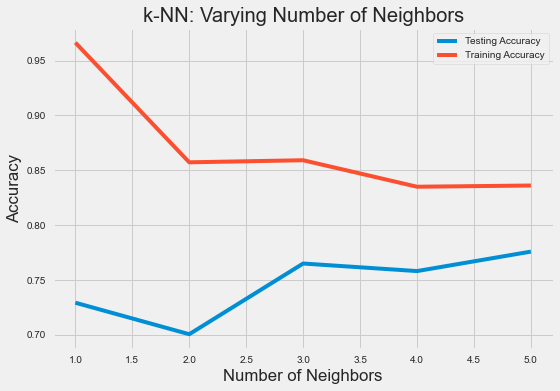

In [67]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 6)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Try running this for neighbors = range(6-10). This was done because running time for full range took too long.

In [ ]:
%%time
# Setup arrays to store train and test accuracies
neighbors = np.arange(6, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [198]:
test_accuracy

array([0.772])

### Regenerate model for K=...

In [ ]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=6)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [12]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

NameError: name 'y_test' is not defined

In [ ]:
'''
# training a linear SVM classifier 
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 
'''

In [ ]:
'''
# print accuracy, confusion matrix, and  classification report
print('accuracy:', accuracy)
print(cm)

print(classification_report(y_test, svm_predictions))
'''

### Tensorflow Deep Learning Regression Model

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import warnings
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#Reset TF session parameters
#tf.keras.backend.clear_session()

In [ ]:
#define variables for tensorflow regressor
X = df_regressor_dummies
y = df_regressor_dummies['Next Year % Chronically Absent']

#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
#Split features from labels
train_features = X_train.copy()
test_features = X_test.copy()

train_labels = train_features.pop('Next Year % Chronically Absent')
test_labels = test_features.pop('Next Year % Chronically Absent')

In [ ]:
#see how different the ranges of each feature are.
X_train.describe().transpose()[['mean', 'std']]

In [ ]:
#build normalization layer
normalizer = preprocessing.Normalization()

In [ ]:
#adapt it to the data
normalizer.adapt(np.array(train_features))

In [ ]:
#this calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

#### Tensorflow Linear regression
Before building a DNN model, start with a linear regression.

In [ ]:
#Build the sequential model using the Normalization layer that was adapted to the whole dataset.
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
#call this model on a batch of inputs, producing produces units=1 outputs for each example
linear_model.predict(train_features[:10])

In [ ]:
#configure the training procedure 
#define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam)
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
#execute the training

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=20,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
#Visualize the model's training progress using the stats stored in the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history, y_lim=10):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, y_lim])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Next Year % Chronically Absent]')
  plt.legend()
  plt.grid(True)

In [ ]:
#visualize training and validation error
plot_loss(history, 35)

In [ ]:
#Collect the results on the test set, for later:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

#### Tensorflow DNN Regression

In [ ]:
#define function to build and compile the model
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(69, activation='relu'),
      layers.Dense(69, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
#Build the sequential model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=20)

In [ ]:
plot_loss(history)

In [ ]:
#Collect the results on the test set:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Tensorflow Model Performance

In [ ]:
#check the test-set performance
pd.DataFrame(test_results, index=['Mean absolute error [Next Year % Chronically Absent]']).T

Results match the validation error seen during training on dnn_model, not linear_model.

#### Make predictions

In [ ]:
#look at the errors made by the model when making predictions on the test set
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Next Year % Chronically Absent]')
plt.ylabel('Predictions [Next Year % Chronically Absent]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
#look at the error distribution:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Next Year % Chronically Absent]')
_ = plt.ylabel('Count')

In [ ]:
#r2_score(, y_tr_pred), 
r2_score(test_labels, test_predictions)

## Choose Model + Feature Importance 

Best performing model is in terms of overall accuracy random forest classifier (79% Accuracy. In many cases school districs would be most focused on the 'High' rates of Chronic Absenteeism (**Meaning... insert number..)**. For the 'High' class Random forest classifer 

     
It wil depend on what a district needs to manage more, False Positives or False Negatives, in deciding which model is best in reality. 

- too many False positives = may be ok for school districts with less constraintes (ie. larger budgets, more time for this kind of initiative), as they may want to ensure they got all the schools & groups that are at risk of high chronic absenteeism.
- too many False negatives = may be ok for school disctricts with more constraints (ie. smaller budgets, less time for this kind of initiative), as they may want to ensure a school/group they focus on will really need it.


So the Random Forrest Model would be a great choice if you want to ensure you limited False Positives (and were ok with under-identifying schools/groups that are at risk of high chronic absenteeism), because the precision is higher while the recall is lower: 

'High' Next_Year_Chronic Absenteesim:
- precision: 0.74
- recall: 0.58
- f1-score: 0.65 
- support: 13169
    
However if you wanted to ensure you limited False Negatives (and were ok with over-identifying schools/groups that are at risk of high chronic absenteeism), then the Naive Bayes Classifer (49% Accuracy) would be the way to go, because although the precision is low the recall is much higher than other models:

'High' Next_Year_Chronic Absenteesim:
- precision: 0.36 
- recall: 0.79
- f1-score: 0.50
- support: 13169
  
But if you wanted the most balanced model the Descision Tree (76% accuracy) may be the best choice as its precision vs. recall for the 'High' class have the least difference.
        
'High' Next_Year_Chronic Absenteesim:
- precision: 0.61  
- recall: 0.68 
- f1-score: 0.64
- support: 13169

This model is also incredibly straightforward to explain (albeit not that helpful in new information) to schools. As it predicts any school/group that has:

- attendance above 95.5% as 'Low' Next_Year_Chronic Absenteesim 
- attendance between 88.45% and 95.5% as 'Medium' Next_Year_Chronic Absenteesim
- attendance below 88.45% as 'High' Next_Year_Chronic Absenteesim

In [80]:
X.columns[19]

'Year_2015-16'

Feature ranking:
1. feature 1 (0.325494)
2. feature 0 (0.304466)
3. feature 68 (0.010955)
4. feature 19 (0.010258)
5. feature 18 (0.010231)
6. feature 17 (0.010077)
7. feature 20 (0.009600)
8. feature 6 (0.008036)
9. feature 15 (0.007881)
10. feature 26 (0.007849)
11. feature 28 (0.007798)
12. feature 37 (0.007762)
13. feature 61 (0.007394)
14. feature 7 (0.007305)
15. feature 8 (0.007246)
16. feature 27 (0.007191)
17. feature 30 (0.007183)
18. feature 3 (0.007077)
19. feature 34 (0.006896)
20. feature 9 (0.006869)
21. feature 23 (0.006455)
22. feature 10 (0.006380)
23. feature 22 (0.006335)
24. feature 2 (0.006295)
25. feature 25 (0.005905)
26. feature 24 (0.005889)
27. feature 31 (0.005864)
28. feature 62 (0.005605)
29. feature 13 (0.005553)
30. feature 33 (0.005482)
31. feature 11 (0.005461)
32. feature 12 (0.005424)
33. feature 45 (0.005334)
34. feature 66 (0.005026)
35. feature 46 (0.004975)
36. feature 4 (0.004973)
37. feature 14 (0.004864)
38. feature 38 (0.004781)
39. feature 2

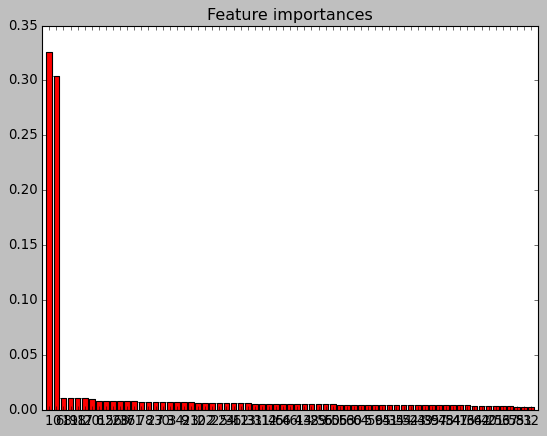

In [78]:
#plot feature importance for random forest classifier model...
importances = rf_class.feature_importances_
std = np.std([rf_class.feature_importances_ for tree in rf_class.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
#save model for later use
#dnn_model.save('dnn_model')

In [ ]:
#reload the model, test if identical output
'''
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)
'''    

In [ ]:
#pd.DataFrame(test_results, index=['Mean absolute error [Next Year % Chronically Absent]']).T

### Saved Best Model

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))
 


In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

## Notes /Summary

### To do...
- xLook at modeling springboard docs
- xdo other models (**deep learning**, naive bayes, svm)
- x?tune descion tree (why lower performing?)
- xvisualize decision tree (look at my springboard decision tree project).. 
- xlook at springboard projects for classfication
- xdo a few regression models (random forest)
- x**tune hyperparamters**
- Feature importance
- predict next years on 2018-2019 data (look at and compare with today's data)

In [ ]:
#remember because of time series split is a form of cross validation...

In [ ]:
#a classification model, you should implement both an entropy model and a Gini impurity model. 


In [68]:
#need to do feature importance before dropping `% Chronically Absent!!`

- Fit your models with a training dataset
- Review model outcomes — Iterate over additional models as needed
- Identify the final model that you think is the best model for this project
    - Not always the most accurate (think about what I want my model to best predict ('high' chronic absentee schools)
        - too many False positives = ok for schools with larger budgets, want to ensure they got all the schools
        - too many False negatives = ok for schools with smaller budgets? want to ensure a school they focus on will really need it

- need to generate more features, https://github.com/springboard-curriculum/featuretools/blob/master/Feature%20Engineering.ipynb
- import other dataframes from nycopen data

We will try to turn chronic absenteeism from a multi class categorical variable to a binary variable.. As we are concerned mostly with whether Chronic Absenteeism is 'High' or not.

In [ ]:
#Turn chronic absenteeism from multi class to binary
1 = High
0 = Low
    
# defining function to check price 
def fun(num): 
  
    if num< (mean - std): 
        return "Low"
  
    elif num>= (mean - std) and num <= (mean + std): 
        return "Medium"
    
    elif num > (mean+ std):
        return "High"
  
    else: 
        return np.nan